In [71]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import random as ra

from skimage.morphology import skeletonize
import networkx as nx
from scipy.ndimage import distance_transform_edt

import os
import re

In [72]:
input_size = 784
hidden_size0 = 32
hidden_size1 = 16
out_size = 10

epochs = 10
batch_size = 1000 #size just for loading more data easily
learning_rate = 0.001

In [73]:
train_dataset = datasets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [74]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size0, hidden_size1, out_size):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, hidden_size0)     #784 - 32
        self.fc1 = nn.Linear(hidden_size0, hidden_size1)   #32 - 16
        self.fc2 = nn.Linear(hidden_size1, out_size)       #16 - 10
        self.tanh = nn.Tanh()
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.fc0.weight, gain=nn.init.calculate_gain('tanh')) 
        nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('tanh'))

    def forward(self, x):
        x0 = self.tanh(self.fc0(x))
        x1 = self.tanh(self.fc1(x0))
        out = self.fc2(x1)
        return out, [x0, x1, out]

In [75]:
net = Net(input_size, hidden_size0, hidden_size1, out_size)
CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()

net.load_state_dict(torch.load('02_ffn_mnist_full.pth'))

<All keys matched successfully>

In [76]:
def extract_concepts(img):
    img_np = img.cpu().numpy()
    filtered = img_np > 0.5 #becuase skeleton works on binary 1, 0 data

    skeleton = skeletonize(filtered)
    skeleton_np = skeleton.astype(bool)

    size = 10
    maxoverlap = 4
    height, width = 28, 28

    neighbors_offsets = [(dy, dx) for dy in [-1,0,1] for dx in [-1,0,1] if not (dy == 0 and dx == 0)]

    def get_neighbors(p):
        y, x = p
        result = []
        for dy, dx in neighbors_offsets:
            ny, nx = y + dy, x + dx
            if 0 <= ny < height and 0 <= nx < width and skeleton_np[ny, nx]:
                result.append((ny, nx))
        return result

    groups = []
    groups_sets = []

    def dfs(path, visited):
        if len(path) == size:
            path_set = set(path)
            if not any(len(path_set & g) > maxoverlap for g in groups_sets):
                groups.append(np.array(path))
                groups_sets.append(path_set)
            return

        candidates = set()
        for p in path:
            for n in get_neighbors(p):
                if n not in visited:
                    candidates.add(n)

        for n in candidates:
            visited.add(n)
            dfs(path + [n], visited)
            visited.remove(n)

    all_pixels = list(zip(*np.nonzero(skeleton_np)))

    for start in all_pixels:
        dfs([start], set([start]))

    tensor_groups = torch.stack([
        torch.zeros((height, width), dtype=torch.uint8).index_put_(
            (torch.tensor(g[:, 0]), torch.tensor(g[:, 1])), 
            torch.ones(len(g), dtype=torch.uint8)
        ) for g in groups
    ])

    original_clusters = torch.zeros_like(tensor_groups)
    original_clusters = []

    for i in range(tensor_groups.shape[0]):
        mask = tensor_groups[i].numpy()
        inverted_mask = 1 - mask
        distance = distance_transform_edt(inverted_mask)
        within_range_mask = (distance <= 2).astype(np.float32)
        new_input = torch.from_numpy(img_np * within_range_mask).float()
        original_clusters.append(new_input)

    return tensor_groups, original_clusters

In [77]:
inputs, labels = next(iter(test_loader))

In [78]:
#this and the next cell were for the extraction of localised concepts from the MNIST digits.
#unfortunately the dfs (depth-first search) algorithm only runs on CPU, making the process longer.
#It is therefore commented out, after having been used once.

digit_ints = [i for i in range(10)]
used_indices = []

In [79]:
for _ in range(0):
    for dig in digit_ints:
        while True:
            ind = ra.randrange(0, len(inputs))
            if labels[ind] == dig and ind not in used_indices:
                #used_indices.append(ind)
                img = inputs[ind].squeeze()
                break

        #tensor_groups, original_clusters = extract_concepts(img)
        #torch.save({'tensor_groups': tensor_groups,'original_clusters': original_clusters}, f"somefolder/concepts_dig_{dig}_ind{ind}.pt")


In [80]:
pattern = re.compile(r'dig_(\d+)_ind(\d+)\.pt$')

files = []
for filename in os.listdir('stored_concepts'):
    match = pattern.search(filename)
    if match:
        dig = int(match.group(1))
        ind = int(match.group(2))
        files.append((dig, ind, filename))

files.sort()
used_indices = [ind for _, ind, _ in files]
original_clusters_list = []

for idx in used_indices:
    data = torch.load(f"stored_concepts/concepts_dig_{labels[idx]}_ind{idx}.pt")
    original_clusters = data['original_clusters']
    original_clusters_list.append(original_clusters)
    



In [81]:
#storing activations:
#forward pass returns out, [x0, x1, out]

def input_to_activation(inp):
    inp = inp.view(-1)
    net.eval()
    with torch.no_grad():
        _, activation_list = net(inp)

        return activation_list
all_activations = []

for idx in used_indices:
    for idx2 in range(len(original_clusters_list[used_indices.index(idx)])):
        act_list = input_to_activation(original_clusters_list[used_indices.index(idx)][idx2].cuda())
        all_activations.append([act_list, (idx, idx2)])

In [82]:

def find_most_similar(all_activations, target, threshold):
    target_0, target_1, target_2 = target
    
    best_matches = []

    for i, triple in enumerate(all_activations):
        a0, a1, a2 = triple[0]

        d0 = torch.norm(a0 - target_0) #norm means euclidean dist
        d1 = torch.norm(a1 - target_1)
        d2 = torch.norm(a2 - target_2)
        total_distance = d0 + d1 + d2 #d0*0 + d1*0 + d2 is actually not too bad, has variation in hidden layer, but consistent in output, meaning different recombinations, same out

        if total_distance > threshold:
            continue
        else:
            best_matches.append([triple, total_distance, i])

    return best_matches


23

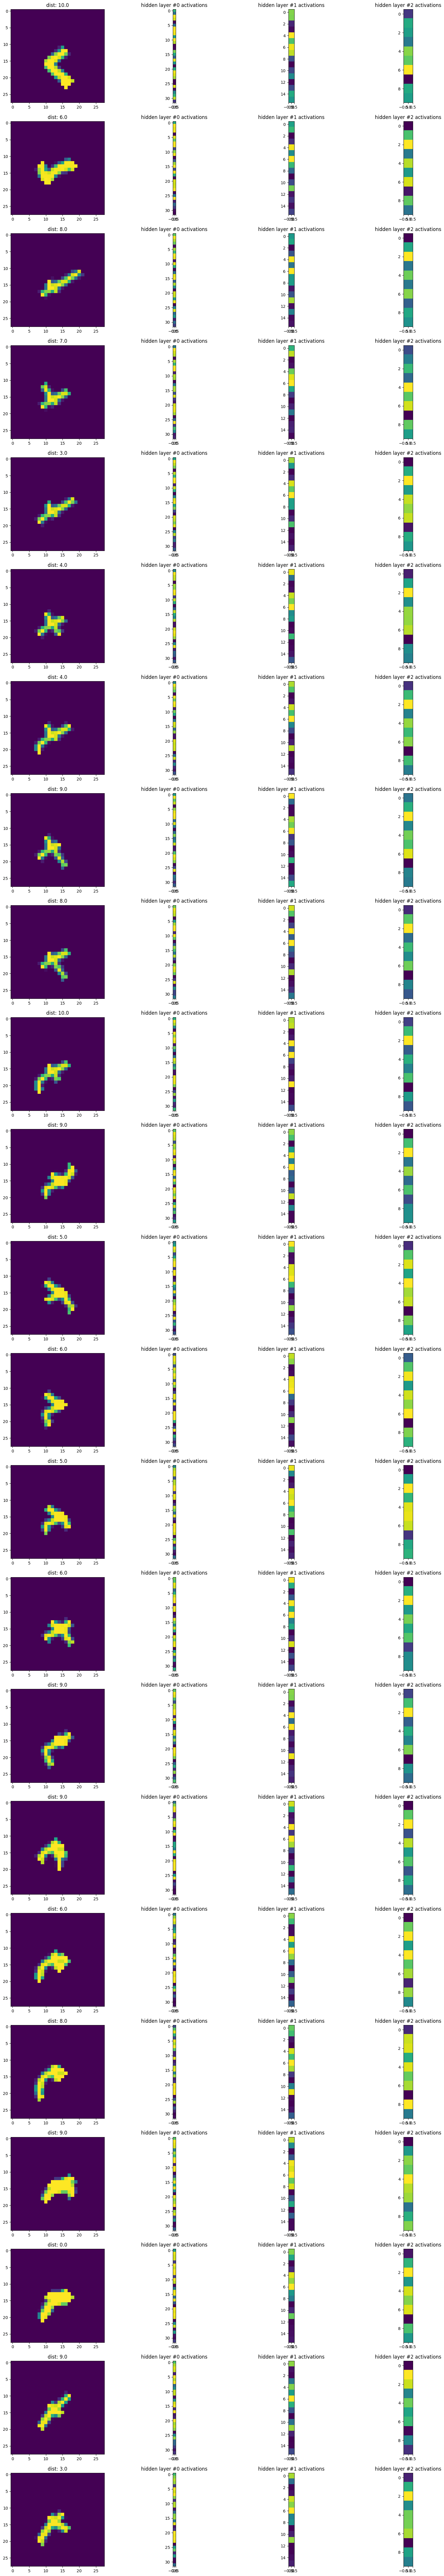

In [83]:

tar = all_activations[ra.randint(0, len(all_activations)-1)][0]
matches = find_most_similar(all_activations, tar, 10)
plt.figure(figsize=(20, len(matches)*5))

for i, match in enumerate(matches):
    triple = match[0]
    dist = match[1]
    ind = match[2]

    idx, idx2 = all_activations[ind][1]

    cluster = original_clusters_list[used_indices.index(idx)][idx2].cuda()

    plt.subplot(len(matches), 4, i*4+1)
    plt.imshow(cluster.cpu())
    plt.title(f"dist: {torch.round(dist)}")

    for j, vector in enumerate(triple[0]):
        s = vector.shape[0]
        plt.subplot(len(matches), 4, i*4+1+j+1)
        plt.imshow(vector.view(s, 1).cpu())
        plt.title(f"hidden layer #{j} activations")

len(matches)



In [ ]:
#another indication of neurons not actually encoding concepts, but similar pixel arrangements, 
#because they focus on scattered pixel clusters overfitting on the MNIST dataset, rather then 
#learning concepts like humans (e.g., has a loop, which means a stroke going in a circle until back, 
#and a stoke means much something much longer than wide used for characters)
#-> this is the human reasoning that is happening automatically, which modern AI lacks.

#scattered neuron attention makes neuron recognising human concepts very unlikely, since human concepts are normally localised and continuously connected pixels.
#therefore the neurons wouldn't have such a scattered attention, inevitably taking into account all the different pixels, but they do, because they don't learn concepts.
#They overfit on pixel arrangements and style, which I will further elaborate on in 05_model_limitations.ipynb and in the paper.